Prilikom obrade teksta, osim *one-hot* reprezentacija reci u kojima se na pozicijama koje odgovaraju indeksima reci u vokabularu reci nalaze jedinice, a na ostalim pozicijama nule, koriste se i takozvane ugnjezdene (eng. embedded) reprezentacije reci. One predstavljaju guste kratke vektorske ekvivalente reci koje cuvaju semantiku reci. 
<br>
Postoji nekoliko nacina generisanja ovakvih reprezentacija. Neki od njih su bazirani na faktorizaciji rec-kontekst matrice npr. latentna semanticka analiza, a neki su bazirani na prediktivnim modelima jezika i neuronskim mrezama. Na primer, [**word2vec**](https://code.google.com/archive/p/word2vec/) i [**Glove**](https://nlp.stanford.edu/projects/glove/) su dve cesto koriscenje kolekcije pritreniranih reprezentacija reci.

Ovaj primer priblizava koriscenje *Embedded* sloja koji postoji u Keras biblioteci kojim se, usput, mogu uciti reprezentacije reci. Korpus koji se koristi predstavlja bazu filmskih pregleda (IMDB kolekcija), a zadatak koji se resava je klasifikacija ovih pregleda na pozitivne i negativne (tzv. analiza sentimenata).

In [26]:
import numpy as np
from matplotlib import pyplot as plt

In [27]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.datasets import imdb
from keras import preprocessing

In [28]:
# Prilikom obrade pregleda nece se razmatrati ceo vokabular (skup svih reci jednog jezika) vec samo npr. 10000 najfrekventnijih reci. 
# Sve reci koje se pojave u pregledima, a nisu u ovom skupu, imace reprezentaciju koja odgovara nepoznatoj reci. To je obicno nula vektor.
max_features = 10000

# Duzina pojedinacnih pregleda se ogranicava na 20 reci.
# Ovo su vrlo kratke duzine, odabrane su zbog lakseg treniranja mreze. 
maxlen = 20 

Ucitavaju se skupovi podataka za ucenje i testiranje, ispituju se njegove dimenzije i vrsi se prilagodjavanje duzina.

In [29]:
(x_train, y_train), (x_test, y_test)= imdb.load_data(num_words=max_features)

In [30]:
print('Training set shape: {}'.format(x_train.shape))
print('Testing set shape: {}'.format(x_test.shape))

Training set shape: (25000,)
Testing set shape: (25000,)


In [31]:
# primer jednog filmskog pregleda: 
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [32]:
negative = np.sum(y_train == 1)
positive = np.sum(y_train == 0)

In [33]:
print('Number of positive reviews: {}'.format(positive))
print('Number of negative reviews: {}'.format(negative))

Number of positive reviews: 12500
Number of negative reviews: 12500


In [34]:
# pad_sequences je funkcija koja se koristi za ujednacavanje duzina sekvenci.
# U zavisnosti od argumenata koji se zadaju, moze dopuniti sekvencu odgovarajucim vrednostima ili je svesti na zeljenu duzinu odsecanjem. 
# U ovom primeru svi pregledi se svode na duzinu maxlen - oni koji su kraci bice dopunjeni nulama, a oni koji su duzi bice skraceni.
# sekvence se ravnaju po kraju!
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen = maxlen)

In [35]:
print(x_train[0])

[  65   16   38 1334   88   12   16  283    5   16 4472  113  103   32   15
   16 5345   19  178   32]


In [36]:
print(x_train.shape)

(25000, 20)


In [37]:
# duzina ugnjezdene reprezentacije reci
# 8 je vrlo kratka reprezentacija - ovde je odabrana samo zbog brzeg treniranja
embedding_dimensionality = 8

Smisao ugnjezdenog sloja je da svaku rec vokabulara predstavi kao vektorsku reprezentaciju zeljene duzine. Ove reprezentacije se uce u toku treniranja mreze. Motivacija za ucenje reprezentacija, a ne koriscenje pritreniranih modela, lezi u pracenju specificnih semantickih relacija domena.

Ulaz u sloj je matrica oblika (samples, sequence_length), a izlaz matrica oblika (samples, sequence_length, embedding_dimensionality). 

In [38]:
model = Sequential()
model.add(Embedding(max_features, embedding_dimensionality, input_length = maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_3 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [41]:
epoches = 10
batch_size = 32

history = model.fit(x_train, y_train, epochs=epoches, batch_size=batch_size, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 2s 100us/step - loss: 0.6759 - acc: 0.6048 - val_loss: 0.6398 - val_acc: 0.6808
Epoch 2/10
20000/20000 [==============================] - 2s 91us/step - loss: 0.5658 - acc: 0.7427 - val_loss: 0.5468 - val_acc: 0.7204
Epoch 3/10
20000/20000 [==============================] - 2s 91us/step - loss: 0.4752 - acc: 0.7807 - val_loss: 0.5113 - val_acc: 0.7384
Epoch 4/10
20000/20000 [==============================] - 2s 88us/step - loss: 0.4264 - acc: 0.8078 - val_loss: 0.5008 - val_acc: 0.7450
Epoch 5/10
20000/20000 [==============================] - 2s 89us/step - loss: 0.3931 - acc: 0.8256 - val_loss: 0.4981 - val_acc: 0.7536
Epoch 6/10
20000/20000 [==============================] - 2s 97us/step - loss: 0.3668 - acc: 0.8396 - val_loss: 0.5014 - val_acc: 0.7530
Epoch 7/10
20000/20000 [==============================] - 2s 101us/step - loss: 0.3435 - acc: 0.8533 - val_loss: 0.5052 - val_ac

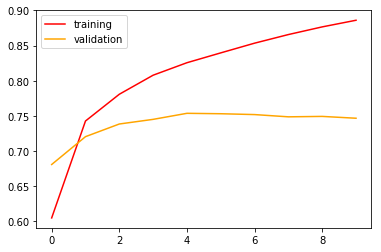

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(range(epoches), acc, color='red', label='training')
plt.plot(range(epoches), val_acc, color='orange', label='validation')
plt.legend(loc='best')

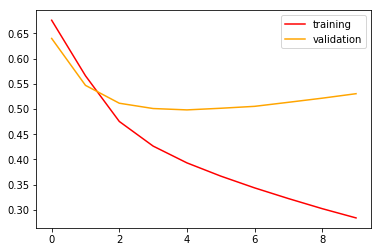

In [43]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(range(epoches), loss, color='red', label='training')
plt.plot(range(epoches), val_loss, color='orange', label='validation')
plt.legend(loc='best')

** Zadatak: **
* Eksperimentisati sa razlicitim velicinama pregleda.
* Eksperimentisati sa razlicitim velicinama ugnjezdenih reprezentacija reci.